# Classification

**In this notebook:**
* loading spam and non spam data
* define classification pipeline 
* train model
* predict spam or non spam
* evaluate test results

## Imports

In [ ]:
!pip install pyspark

In [1]:
import os
import pandas as pd

from pyspark import SparkContext, SparkConf
from pyspark.sql import *
from pyspark.sql import functions as F
from pyspark.sql.functions import *
from pyspark.ml.feature import * 
from pyspark.ml import Pipeline
from pyspark.ml.classification import LinearSVC, LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Enviroment

 Setting up the Spark configuration with parameter setting for the cluster. Setting up the connection to the Spark cluster.

In [2]:
conf = SparkConf().setAppName('HW2').setMaster("local[8]")
sc = SparkContext(conf=conf)
sqlContext = SQLContext(sc)

## Data Loading

Loading data into pyspark DataFrames.

In [18]:
data_path = "../../../data/HW2/spam-datasets/"

In [19]:
nospam_testing = (
    sqlContext.read.format("csv")
    .options(header="false", inferSchema="True", delimiter="\t")
    .load(os.path.join(data_path, "nospam_testing.txt"))
).cache()
nospam_testing = nospam_testing.withColumn("label", F.lit(0))

spam_testing = (
    sqlContext.read.format("csv")
    .options(header="false", inferSchema="True", delimiter="\t")
    .load(os.path.join(data_path, "spam_testing.txt"))
).cache()
spam_testing = spam_testing.withColumn("label", F.lit(1))

spam_training = (
    sqlContext.read.format("csv")
    .options(header="false", inferSchema="True", delimiter="\t")
    .load(os.path.join(data_path, "spam_training.txt"))
).cache()
spam_training = spam_training.withColumn("label", F.lit(1))

nospam_training = (
    sqlContext.read.format("csv")
    .options(header="false", inferSchema="True", delimiter="\t")
    .load(os.path.join(data_path, "nospam_training.txt"))
).cache()
nospam_training = nospam_training.withColumn("label", F.lit(0))

In [20]:
training = nospam_training.union(spam_training)
testing = nospam_testing.union(spam_testing)

In [21]:
training.describe().show()

+-------+--------------------+-------------------+
|summary|                 _c0|              label|
+-------+--------------------+-------------------+
|  count|                4460|               4460|
|   mean|               645.0|0.13408071748878925|
| stddev|                 NaN| 0.3407772243049732|
|    min| &lt;#&gt;  in mc...|                  0|
|    max|… and don‘t worry...|                  1|
+-------+--------------------+-------------------+



In [22]:
spam_training.count()

598

## Pipeline

Setting up a ml pipeline, including **extraction, transformation and classification** algorithms.

I tried different pipeline steps including: 
* tokenizer
* regex tokenizer
* stop words remover
* countvectorizer
* hashingTF
* idf
* normalizer
* standard scaler
* logistic regression
* linear SVC
* ...

In following I compare a linear regression pipeline with a svm:

In [73]:
# Split subjects into words (tokens)
#tokenizer = Tokenizer(inputCol="_c0", outputCol="words")
tokenizer = RegexTokenizer(inputCol="_c0", outputCol="words",  pattern="\\W")
# Delete Stop words
#remover = StopWordsRemover(inputCol="words", outputCol="filtered")

# Hash tokens
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")
#cv = CountVectorizer(inputCol="words", outputCol="features", vocabSize=3, minDF=2.0)

# Weight with idf
idf = IDF(inputCol=hashingTF.getOutputCol(), outputCol="features_weighted")

# Normalize
normalizer = Normalizer(inputCol=idf.getOutputCol(), outputCol="features_normalized")
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)

# Define model
lsvc = LinearSVC()   #Linear SVM
mlr = LogisticRegression() # Logistic Regression

In [74]:
lsvc_pipeline = Pipeline(stages=[tokenizer, 
                            #remover, 
                            hashingTF, 
                            idf, 
                            normalizer, 
                            lsvc])
mlr_pipeline = Pipeline(stages=[tokenizer, 
                            #remover, 
                            hashingTF, 
                            idf, 
                            normalizer, 
                            mlr])

## Cross Validation

I tried different:
* number of features: downsampling to 1000 worked the best
* reg param: 0.01 worked the best
* max iteration: 20 worked the best

In [75]:
# SVM
paramGrid = ParamGridBuilder() \
    .addGrid(hashingTF.numFeatures, [100, 1000, 1100]) \
    .addGrid(lsvc.regParam, [0.1,0.05, 0.01]) \
    .addGrid(lsvc.maxIter, [5, 10, 20]) \
    .build()

crossval = CrossValidator(estimator=lsvc_pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=10)  

# Run cross-validation
lsvc_model = crossval.fit(training)

In [76]:
# Regression
mlr_paramGrid = ParamGridBuilder() \
    .addGrid(hashingTF.numFeatures, [100, 1000, 1100]) \
    .addGrid(mlr.regParam, [0.1,0.05, 0.01]) \
    .addGrid(mlr.maxIter, [5, 10, 20]) \
    .build()

mlr_crossval = CrossValidator(estimator=mlr_pipeline,
                          estimatorParamMaps=mlr_paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=10)  

# Run cross-validation
mlr_model = mlr_crossval.fit(training)

## Evaluation

I evaluated mainly on the accuracy and on the false positive rate. The best accuracy I achieved was: 96.5%

In [77]:
lsvc_predictions = lsvc_model.transform(testing)
mlr_predictions = mlr_model.transform(testing)

In [78]:
# Number of fasely classified samples
lsvc_false = lsvc_predictions.where(lsvc_predictions.label != lsvc_predictions.prediction).count()
mlr_false = mlr_predictions.where(mlr_predictions.label != mlr_predictions.prediction).count()
print(f'SVM misclassified {lsvc_false} samples, Regression misclassified {mlr_false} samples.')

SVM misclassified 30 samples, Regression misclassified 36 samples.


In [79]:
# Evaluation modul
def evaluate(predictions):
    cm = predictions.select("label", "prediction")

    # Accuracy
    acc = cm.filter(cm.label == cm.prediction).count() / cm.count()
    print(f"Model accuracy: {acc} %")

    # ROC
    evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
    print(f"Area under Roc: {evaluator.evaluate(predictions)} %")

    # False positive
    fp = (
        cm.filter(cm.label != cm.prediction).where(cm.prediction == 1).count()
        / cm.count()
    )
    print(f"False positives: {fp} %")

    # False negative
    fn = (
        cm.filter(cm.label != cm.prediction).where(cm.prediction == 0).count()
        / cm.count()
    )
    print(f"False negative: {fn} %")

    # Confusion Matrix
    conf_matrix  = confusion_matrix(
        predictions.select("label").toPandas(),
        predictions.select("prediction").toPandas(),)

    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                               display_labels=["nospam", "spam"])
    disp.plot() 


    return acc, cm

Model accuracy: 0.9730700179533214 %
Area under Roc: 0.9895677574155879 %
False positives: 0.005385996409335727 %
False negative: 0.02154398563734291 %


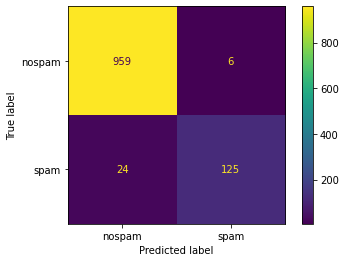

In [80]:
# Evaluate SVM 
lsvc_acc, lsvc_cm = evaluate(lsvc_predictions)

Model accuracy: 0.9676840215439856 %
Area under Roc: 0.9919532635532252 %
False positives: 0.003590664272890485 %
False negative: 0.02872531418312388 %


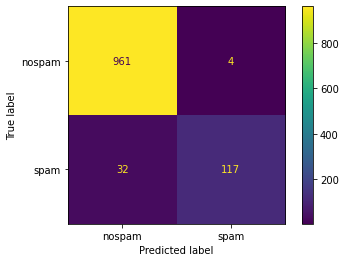

In [81]:
# Evaluate Logistic Regression Model 
mlr_acc, mlr_cm = evaluate(mlr_predictions)

## Save result

In [82]:
with open("Output.txt", "w") as text_file:
    text_file.write("Accuracy: {0}".format(lsvc_acc))